In [1]:
import pandas as pd
import numpy as np
import recmetrics
import matplotlib.pyplot as plt
from surprise import Reader, SVD, Dataset
from surprise.model_selection import train_test_split

# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [ ]:
ratings = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [ ]:
#only consider ratings from users who have rated over n movies
n=1000
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()

In [ ]:
ratings = ratings.query('userId in @users')
print ratings.shape
ratings.head(3)

In [ ]:
# get movie features

rated_movies = ratings.movieId.tolist()
movies = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
#movies = movies[['Action', 'Romance', 'Western', 'Comedy', 'Crime']]
movies.head()

## Long Tail Plot Example

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
recmetrics.LongTailPlot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. I've implemented collaborative filtering using a SVD approach in the surprise package. The surprise package also takes care of the test train split. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

In [ ]:
#format data for surprise
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [ ]:
#train SVD recommender 
algo = SVD()
algo.fit(trainset)

In [ ]:
#make predictions on test set. 
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
test.head()

In [ ]:
#evaluate model with MSE and RMSE
print recmetrics.mse(test.actual, test.cf_predictions)
print recmetrics.rmse(test.actual, test.cf_predictions)

In [ ]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)

In [ ]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [ ]:
#get example prediction
get_users_predictions(156, 10, cf_model)

In [ ]:
#format test data
test = test.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
#make recommendations for all members in the test data
recs = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model)
    recs.append(cf_predictions)
        
test['cf_predictions'] = recs
test.head()

# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

In [ ]:
#make recommendations for all members in the test data
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

recs = []
for user in test.index:
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test['pop_predictions'] = recs
test.head()

# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random movies to every user.

In [ ]:
#make recommendations for all members in the test data

recs = []
for user in test.index:
    random_predictions = ratings.movieId.sample(10).values.tolist()
    recs.append(random_predictions)
        
test['random_predictions'] = recs
test.head()

# Recall

In [ ]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [ ]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

In [ ]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

In [ ]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

# Mark Plot

In [ ]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.MarkPlot(mark_scores, model_names=names, k_range=index)

# Coverage

In [ ]:
catalog = ratings.movieId.unique().tolist()
random_coverage = recmetrics.coverage(random_predictions, catalog)
pop_coverage = recmetrics.coverage(pop_predictions, catalog)
cf_coverage = recmetrics.coverage(cf_predictions, catalog)

# Coverage Plot

In [ ]:
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
recmetrics.CoveragePlot(coverage_scores, model_names)

# Personalization

In [ ]:
example_predictions = [
    ['1', '2', 'C', 'D'],
    ['4', '3', 'm', 'X'],
    ['7', 'B', 't', 'X']
]

In [ ]:
recmetrics.personalization(predicted=example_predictions)

# Intra-list Similarity

In [ ]:
example_predictions = [
    [3, 7, 5, 9],
    [9, 6, 12, 623],
    [7, 894, 6, 623]
]

In [ ]:
feature_df = movies[['Action', 'Comedy', 'Romance']]

In [ ]:
recmetrics.intra_list_similarity(example_predictions, feature_df)

# Classification Probability Plot

In [5]:
#make fake classification probability data
class_one_probs = np.random.normal(loc=.7, scale=0.1, size=1000)
class_zero_probs = np.random.normal(loc=.3, scale=0.1, size=1000)
actual = [1] * 1000
class_zero_actual = [0] * 1000
actual.extend(class_zero_actual)

pred_df = pd.DataFrame([np.concatenate((class_one_probs, class_zero_probs), axis=None), actual]).T
pred_df.columns = ["probability", "truth"]
pred_df.head()

,probability,truth
0,0.715493,1.0
1,0.642644,1.0
2,0.603956,1.0
3,0.676178,1.0
4,0.681016,1.0


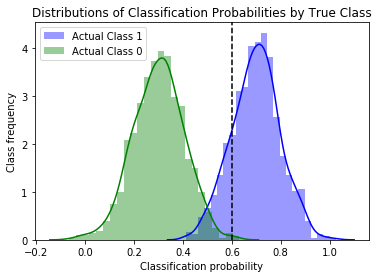

In [6]:
recmetrics.ClassDistributionPlot(pred_df, .6)